<a href="https://colab.research.google.com/github/tatsuhiko-suyama/colab_pub/blob/main/4_30_BS_init_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plotly

In [ ]:
import numpy as np
import pandas as pd
import torch
torch.set_default_dtype(torch.double)
import torch.nn as nn
import time
from scipy.stats import norm


class Config:
    def __init__(self):
        # オプションの基本的なパラメータ
        self.maturity = 100  # 満期までの期間
        self.strike = 100 # ストライク価格
        self.branches_bin = 2  # 二項モデルの分岐数
        self.branches=3#３項モデルの分岐数
        self.S_0 = 100  # 初期株価
        # モデル特有のパラメータ
        self.sigma_ave = 0.3
        self.mu_ave = 0.05-self.sigma_ave**2/2
        self.nu = 0.005
        self.zeta = 0.35
        self.payoff = 'call'  # オプション ('call', 'put', 'strangle','bull','batafrei, etc.)


        # ニューラルネットワークのパラメータ
        self.num_epochs = 10**4  # 学習のエポック数
        self.activation=nn.Tanh()#活性化関数
        self.units=15#中間層の数．合計でunits+2
        #self.model_params = np.array([[0.07, 0.35], [0.03, 0.25]])  # モデルパラメータ ([平均, 標準偏差]のリスト)
        self.model_params = np.array([[0.07, 0.35], [0.03, 0.25],[0.07,0.25],[0.03,0.35]])
        self.hidden_size = 2**10  # 隠れ層のユニット数
        self.input_size = 12  # 入力層のユニット数



        # 計算精度やモデル実行のための追加設定
        torch.cuda.seed_all()#cudaのseedを固定
        torch.manual_seed(0)#cpuのseedを固定
        self.learning_rate = 0.00001  # 学習率
        # 追加で必要な設定があればここに記述
class Normalize(nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()

    def forward(self, x):
        mean = torch.mean(x, dim=0, keepdim=True)
        std = torch.sqrt(torch.var(x, dim=0, keepdim=True, unbiased=False) + 1e-05)
        return (x - mean) / std

normalize = Normalize()


class OptionBase:
    def __init__(self, config):
        # コンストラクタでConfigクラスのインスタンスを受け取り、
        # 必要なオプション関連のパラメータを設定
        self.config=config
        self.maturity = config.maturity
        self.strike = config.strike
        self.branches_bin=config.branches_bin
        self.S_0 = config.S_0
        self.branches = config.branches
        self.nu=config.nu
        self.zeta=config.zeta
        self.dt=1/self.maturity
        self.model_params=config.model_params
        self.models=self.model_params.shape[0]
        # upとdownはオプションの価格計算モデルによって異なるため、
        # これらの値は具体的な子クラスで設定する
        self.sigma_ave=config.sigma_ave # @param
        self.mu_ave=config.mu_ave#@param
        self.up_bin =np.exp(self.mu_ave*self.dt+self.sigma_ave*np.sqrt(self.dt))#@param
        self.down_bin =np.exp(-2*self.sigma_ave*np.sqrt(self.dt))#@param
        # 上昇率

        self.up = np.exp(self.nu*self.dt+self.zeta*np.sqrt(self.dt))#@param
        # 下落率
        self.down = np.exp(-self.zeta*np.sqrt(self.dt))#@param

        # 他にもオプション価格計算やヘッジに必要なパラメータがあれば追加

    def stock_price_T(self, maturity, branches, up, down, S_0):
        # 株価の時間発展を計算するロジック
        # この関数は、満期時の株価の配列を返す
        stock_price=np.array(S_0 * up ** maturity * down ** np.arange(0, (branches - 1) * maturity + 1, 1),dtype=np.float64)
        assert np.min(stock_price)>=0
        return stock_price
    #パラメータから確率測度を計算
    def param_to_prob(self,mu, sigma,nu,zeta,dt):
        prob=np.array([1/2*(sigma/zeta)**2+np.sqrt(dt)/(2*zeta)*(mu-sigma**2/2-nu),1-(sigma/zeta)**2,1/2*(sigma/zeta)**2-np.sqrt(dt)/(2*zeta)*(mu-sigma**2/2-nu)]  )
        assert np.min(prob)>=0#確率測度の定義を満たしているか確認
        assert np.isclose(np.sum(prob),1,atol=1e-15)
        return prob

    def to_numpy(self,x: torch.Tensor) -> np.ndarray:
        return x.cpu().detach().numpy().reshape(-1)
class OptionHedging(OptionBase):
    def __init__(self, config, init_cost, prob_list):
        super().__init__(config)
        self.init_cost = init_cost
        self.prob_list = prob_list
        self.payoff = self.config.payoff

    def calculate_table(self):
        """
        ヘッジング戦略の計算
        """
        assert self.maturity > 0, "Maturity must be a positive integer"
        assert self.branches > 0, "Branches must be a positive integer"
        assert self.up > 1, "Up factor must be greater than 1"
        assert 1 > self.down > 0, "Down factor must be between 0 and 1"
        assert self.S_0 >= 0, "Initial stock price must be non-negative"
        assert self.init_cost >= 0, "Initial cost must be non-negative"

        df = pd.DataFrame(columns=['a_n', 'b_n', 'c_n', 'stock_price', 'Cond_Exp_a', 'Cond_Exp_a_Delta_S', 'Cond_Exp_a_Delta_S_sq',
                                   'Cond_Exp_b', 'Cond_Exp_b_Delta_S', 'Cond_Exp_c', '(Cond_Exp_a_Delta_S)^2/Cond_Exp_a_Delta_S_sq',
                                   '(Cond_Exp_a_Delta_S)(Cond_Exp_b_Delta_S)/Cond_Exp_a_Delta_S_sq', '(Cond_Exp_b_Delta_S)^2/Cond_Exp_a_Delta_S_sq'])

        def stock_price_T():
            return np.array(self.S_0 * self.up ** self.maturity * self.down ** np.arange(0, (self.branches - 1) * self.maturity + 1, 1), dtype=np.float64)

        stock_price = torch.from_numpy(stock_price_T()).cuda()
        a_n = torch.from_numpy(np.ones((self.branches - 1) * self.maturity + 1)).cuda()

         # 支払い条件に応じたb_n, c_nの計算
        if self.payoff == 'call':
            b_n = torch.clamp(stock_price - self.strike, min=0).cuda()
            c_n = b_n ** 2
        elif self.payoff == 'strangle':
            b_n = torch.clamp(80 - stock_price, min=0).cuda() + torch.clamp(stock_price - 120, min=0).cuda()
            c_n = b_n ** 2
        elif self.payoff == 'bull':
            b_n = torch.clamp(stock_price - 80, min=0).cuda() - torch.clamp(stock_price - 120, min=0).cuda()
            c_n = b_n ** 2
        elif self.payoff == 'batafrei':
            b_n = torch.clamp(stock_price - 80, min=0).cuda() - 2 * torch.clamp(stock_price - 100, min=0).cuda() + torch.clamp(stock_price - 120, min=0).cuda()
            c_n = b_n ** 2


        # 条件付き期待値とその他の計算
        for n in np.arange(self.maturity-1,-1,-1):
          prob_tensor=self.prob_list[n]
          a_n= a_n.unfold(0,self.branches, 1)
          b_n=b_n.unfold(0,self.branches, 1)
          c_n= c_n.unfold(0,self.branches, 1)
          stock_price = stock_price.unfold(0,self.branches,1)

          Cond_Exp_a=torch.einsum('ij,ij->i', a_n, prob_tensor)
          Cond_Exp_a_Delta_S=torch.einsum('ij,ij->i', a_n*(stock_price-(stock_price[:,0]/self.up).reshape(-1,1)), prob_tensor)
          Cond_Exp_a_Delta_S_sq=torch.einsum('ij,ij->i', a_n*(stock_price-(stock_price[:,0]/self.up).reshape(-1,1))**2, prob_tensor)
          Cond_Exp_b=torch.einsum('ij,ij->i', b_n, prob_tensor)
          Cond_Exp_b_Delta_S=torch.einsum('ij,ij->i', b_n*(stock_price-(stock_price[:,0]/self.up).reshape(-1,1)), prob_tensor)
          Cond_Exp_c=torch.einsum('ij,ij->i', c_n, prob_tensor)

          stock_price=(stock_price/self.up)[:,0]
          #a, b, cの更新
          a_divide=Cond_Exp_a_Delta_S ** 2 / (Cond_Exp_a_Delta_S_sq)
          a_divide[Cond_Exp_a_Delta_S_sq<1e-20]=0
          a_b_divide=(Cond_Exp_a_Delta_S * Cond_Exp_b_Delta_S) / (Cond_Exp_a_Delta_S_sq)
          a_b_divide[Cond_Exp_a_Delta_S_sq<1e-20]=0
          b_divide=Cond_Exp_b_Delta_S ** 2 / (Cond_Exp_a_Delta_S_sq)
          b_divide[Cond_Exp_a_Delta_S_sq<1e-20]=0
          a_n=Cond_Exp_a-a_divide
          b_n=Cond_Exp_b-a_b_divide
          c_n=Cond_Exp_c-b_divide
        df=pd.concat([df,pd.DataFrame({'a_n' :self.to_numpy(a_n),'b_n':self.to_numpy(b_n),'c_n': self.to_numpy(c_n), 'stock_price': self.to_numpy(stock_price), 'Cond_Exp_a': self.to_numpy(Cond_Exp_a), 'Cond_Exp_a_Delta_S': self.to_numpy(Cond_Exp_a_Delta_S), 'Cond_Exp_a_Delta_S_sq': self.to_numpy(Cond_Exp_a_Delta_S_sq), 'Cond_Exp_b': self.to_numpy(Cond_Exp_b), 'Cond_Exp_b_Delta_S': self.to_numpy(Cond_Exp_b_Delta_S), 'Cond_Exp_c': self.to_numpy(Cond_Exp_c),
                         '(Cond_Exp_a_Delta_S)^2/Cond_Exp_a_Delta_S_sq' : self.to_numpy((Cond_Exp_a_Delta_S)**2/Cond_Exp_a_Delta_S_sq),'(Cond_Exp_a_Delta_S)(Cond_Exp_b_Delta_S)/Cond_Exp_a_Delta_S_sq' : self.to_numpy((Cond_Exp_a_Delta_S)*(Cond_Exp_b_Delta_S)/Cond_Exp_a_Delta_S_sq),'(Cond_Exp_b_Delta_S)^2/Cond_Exp_a_Delta_S_sq' : self.to_numpy((Cond_Exp_b_Delta_S)**2/Cond_Exp_a_Delta_S_sq)})], ignore_index=True)

        # 最終行の価値を計算
        hedge_error = a_n * self.init_cost ** 2 - 2 * b_n * self.init_cost + c_n
        pi_0 = Cond_Exp_b / Cond_Exp_a_Delta_S_sq - self.init_cost * Cond_Exp_a_Delta_S / Cond_Exp_a_Delta_S_sq
        init_cost_opt = b_n / a_n


        hedge_error = a_n * self.init_cost ** 2 - 2 * b_n * self.init_cost + c_n
        pi_0 = Cond_Exp_b_Delta_S / Cond_Exp_a_Delta_S_sq - self.init_cost * Cond_Exp_a_Delta_S / Cond_Exp_a_Delta_S_sq
        init_cost_opt = df.loc[len(df) - 1, 'b_n'] / df.loc[len(df) - 1, 'a_n']

        return hedge_error, pi_0, init_cost_opt, df
class DL_Model_Risk(OptionBase):
    def __init__(self, config):
        super().__init__(config)
        self.payoff=config.payoff
        self.num_epochs = config.num_epochs
        self.net = self._build_model()


        # 各モデルの重みを初期化

        self.net.apply(self.init_weights)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.config.learning_rate)
        self.option_hedging = OptionHedging(config, init_cost=0, prob_list=[])
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('tanh'))
    def calculate_init_cost(self):
        if self.payoff=='call':
            #コール
            Call_T=np.maximum(self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0)-self.strike,0)#満期の支払いを計算
        if self.payoff=='strangle':
            #ストラングル
            Call_T=np.maximum(80-self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0),0)+np.maximum(self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0)-120,0)
        if self.payoff=='bull':
            #ブルスプレッド
            Call_T=np.maximum(self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0)-80,0)-np.maximum(self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0)-120,0)
        elif self.payoff=='batafrei':
            #バタフライスプレッド
            Call_T=np.maximum(self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0)-80,0)-2*np.maximum(self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0)-100,0)+np.maximum(self.stock_price_T(maturity=self.maturity, branches=self.branches_bin, up=self.up_bin,down=self.down_bin, S_0=self.S_0)-120,0)
        risk_neutral_measure=np.array([(1-self.up_bin*self.down_bin)/(self.up_bin-self.up_bin*self.down_bin), (self.up_bin-1)/(self.up_bin-self.up_bin*self.down_bin)])#リスク中立確率を求める

        for n in np.arange(self.maturity-1,-1,-1):
            for i in np.arange(0, (self.branches_bin - 1) * n + 1, 1):
                Call_T[i]=Call_T[i : i+self.branches_bin]@risk_neutral_measure
        init_cost=Call_T[0]
        return init_cost
    def BS_price(self, S, K, r, sigma, T, payoff):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if payoff == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif payoff == 'put':
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        else:
            raise ValueError('payoff must be either "call" or "put"')
    def calculate_prob_list(self):
        # ニューラルネットワークを使ってprob_listを計算
        weight_tensor = torch.zeros(self.maturity, (self.branches-1) * self.maturity - 1, self.model_params.shape[0], requires_grad=True).cuda()
        new_weight_tensor = weight_tensor.clone()


        for n in np.arange(self.maturity-1, 0, -1):

            S=(torch.from_numpy(self.stock_price_T(n,self.branches,self.up,self.down,self.S_0))/self.S_0).cuda().reshape(-1,1)
            current_time=(torch.ones_like(S)*n*self.dt).reshape(-1,1)
            time_span=(torch.ones_like(S)*self.dt).reshape(-1,1)
            input_tensor=torch.concat([time_span,time_span**2,time_span**3,current_time,current_time**2,current_time**3,torch.log(S),torch.log(S)**2,torch.log(S)**3,\
                                torch.sqrt(S), torch.sqrt(S)**3 , torch.sqrt(S)**5],dim=1)
            ST_input_tensor=(input_tensor-torch.mean(input_tensor, dim=0, keepdim=True))/(torch.sqrt(torch.var(input_tensor, dim=0, keepdim=True, unbiased=False)+1e-05))

            new_weight_tensor[n][0:(self.branches-1)*(n+1)-1]=nn.Softmax(dim=1)(self.net(ST_input_tensor.cuda().double()))

        input_tensor=torch.tensor([[self.dt,self.dt**2,self.dt**3,0,0,0,0,0,0,1,1,1],[self.dt,self.dt**2,self.dt**3,0,0,0,0,0,0,1,1,1]]).cuda().double()
        ST_input_tensor=(input_tensor-torch.mean(input_tensor, dim=0, keepdim=True))/(torch.sqrt(torch.var(input_tensor, dim=0, keepdim=True, unbiased=False)+1e-05))
        new_weight_tensor[0][0]=nn.Softmax(dim=1)(self.net(ST_input_tensor.double()))[0]
        weight_tensor = new_weight_tensor

        prob_tensor = torch.zeros(self.maturity, (self.branches-1) * self.maturity - 1, self.branches, requires_grad=True).cuda().double()
        new_prob_tensor=prob_tensor.clone()
        for m in range(self.models):
            new_prob_tensor=new_prob_tensor+torch.ones(self.maturity, (self.branches-1)*self.maturity-1, self.branches, requires_grad=True).cuda()\
                * torch.from_numpy(self.param_to_prob(self.model_params[m, 0], self.model_params[m, 1],self.nu,self.zeta,self.dt)).cuda()*new_weight_tensor[:,:,m].reshape(self.maturity,(self.branches-1)*self.maturity-1,1)

        new_prob_tensor
        prob_list=[]
        for n in range(new_prob_tensor.shape[0]):
            prob_list.append(new_prob_tensor[n][0:(self.branches-1)*n+1].reshape((self.branches-1)*n+1,self.branches))

        return weight_tensor,prob_list
    def _build_model(self):
        #NNの構成
        model = nn.ModuleList()

        model.append(nn.Linear(self.config.input_size, self.config.input_size))
        model.append(nn.Linear(self.config.input_size, self.config.hidden_size))
        model.append(self.config.activation)
        model.append(normalize)

        for _ in range(self.config.units):
            model.append(nn.Linear(self.config.hidden_size,self.config.hidden_size))
            model.append(self.config.activation)
            model.append(normalize)


        model.append(nn.Linear(self.config.hidden_size,self.config.hidden_size))

        model.append(self.config.activation)

        model.append(nn.Linear(self.config.hidden_size,self.config.model_params.shape[0]))




        class NN(nn.Module):
            def __init__(self, layers):
                super(NN, self).__init__()
                self.layers = nn.Sequential(*layers)

            def forward(self, x):
                return self.layers(x)

        return NN(model).cuda()
    def train_network(self):
        torch.cuda.synchronize()
        losses=[]
        weights=[]
        pi_0s=[]
        t0 = time.perf_counter()
        df=pd.DataFrame()

        init_cost = self.calculate_init_cost()

        for epoch in range(self.num_epochs):

            self.optimizer.zero_grad()




        # prob_listとinit_costの計算
            self.weight_tensor,self.prob_list = self.calculate_prob_list()



            # OptionHedgingの属性を更新
            self.option_hedging.prob_list = self.prob_list

            #self.option_hedging.init_cost = self.BS_price(100,self.config.strike,0,0.3,1,'call')
            self.option_hedging.init_cost = self.BS_price(100,80,0,0.3,1,'call')+self.BS_price(100,120,0,0.3,1,'call')-20
            loss, pi_0, init_cost_opt, df = self.option_hedging.calculate_table()
            loss=-loss
            pi_0s.append(pi_0.item())
            weights.append(self.weight_tensor.detach().cpu().numpy())
            losses.append(-loss.item())
            # 定期的に損失を表示
            if epoch % 100==0:

                print(f'epoch : {epoch},pi_0:{pi_0.item()},loss : {-loss.item()}')



            loss.backward()

            self.optimizer.step()

        #全てのモデルを保存
        net_dict = {f'net': self.net.state_dict()}
        torch.save(net_dict, f'/content/drive/MyDrive/MVH_NN/singleNN/net_maturity_{self.config.maturity}_strike_{self.config.strike}_models_{self.config.model_params.shape[0]}_lr_{self.config.learning_rate}_units_{self.config.units}_hiddensize_{self.config.hidden_size}.pth')

        torch.cuda.synchronize()
        elapsed_time = time.perf_counter() - t0
        print(f'Training completed in {elapsed_time} seconds.maturity:{self.config.maturity},lr:{self.config.learning_rate},units:{self.config.units},strike:{self.config.strike},loss:{losses[losses.index(max(losses))]}')

        df=pd.DataFrame([self.maturity,self.strike,losses.index(max(losses)),weights[losses.index(max(losses))][0,0,0],\
                                   pi_0s[losses.index(max(losses))],losses[losses.index(max(losses))],\
                                    int(elapsed_time),np.max(np.gradient(np.maximum.accumulate(losses))[len(losses)-1000:len(losses)]),\
                                         self.config.learning_rate,self.config.units+2,self.config.hidden_size])

        df.index=['満期','行使価格','最大となるエポック','初期ウェイト','初期株式保有数','ヘッジ誤差','処理時間','平均更新量','学習率','中間層の数','ユニット数']
        df=df.T

        df.to_csv(f'/content/drive/MyDrive/MVH_NN/singleNN/df_Markov_models_{self.model_params.shape[0]}_maturity_{self.maturity}_strike_{self.strike}_hidden_size_{self.config.hidden_size}.csv',index=False)
        pd.DataFrame(weights[losses.index(max(losses))].reshape(int(np.size(self.weight_tensor.cpu().detach().numpy())/self.models),self.models))\
        .to_csv(f'/content/drive/MyDrive/MVH_NN/singleNN/weight_strike_{self.strike}_models_{self.model_params.shape[0]}_maturity_{self.maturity}_hidden_size_{self.config.hidden_size}_Markov.csv',index=False)

        import plotly.graph_objects as go

        # 1万個のデータを準備
        losses = np.array(losses)

        # lossesの勾配を計算
        gradient_losses = np.gradient(losses)

        # インデックスの生成（1, 101, 201, ..., 9901）
        indices = np.arange(1, len(losses), 100)

        # lossesとgradient_lossesから指定のインデックスに対応するデータの抽出
        selected_losses = losses[indices]
        selected_gradient_losses = gradient_losses[indices]

        # lossesとgradient_lossesから最大値を取得
        max_loss = np.max(losses)
        max_gradient_loss = np.max(gradient_losses)

        # 最大値のインデックスを取得
        index_max_loss = np.argmax(losses)
        index_max_gradient_loss = np.argmax(gradient_losses)

        # プロットの作成
        fig = go.Figure()

        # lossesの全データと抽出したデータをプロット
        fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses, mode='lines', name='Losses'))
        fig.add_trace(go.Scatter(x=indices, y=selected_losses, mode='markers', name='Selected Losses'))
        fig.add_trace(go.Scatter(x=[index_max_loss], y=[max_loss], mode='markers', marker=dict(size=10, color='Red'), name='Max Loss'))

        # gradient_lossesの全データと抽出したデータをプロット
        fig.add_trace(go.Scatter(x=np.arange(len(gradient_losses)), y=gradient_losses, mode='lines', name='Gradient Losses'))
        fig.add_trace(go.Scatter(x=indices, y=selected_gradient_losses, mode='markers', name='Selected Gradient Losses'))
        fig.add_trace(go.Scatter(x=[index_max_gradient_loss], y=[max_gradient_loss], mode='markers', marker=dict(size=10, color='Green'), name='Max Gradient Loss'))

        # グラフのタイトルと軸ラベルの設定
        fig.update_layout(title=f'ストライク {self.strike}の学習',
                  xaxis_title='エポック数',
                  yaxis_title='ヘッジ誤差')

        # グラフをHTMLファイルとして保存
        fig.write_html(f'/content/drive/MyDrive/MVH_NN/singleNN/hedge_losses_strike_{self.strike}_models_{self.models}_maturity_{self.maturity}_Markov.html')

        # グラフの表示

        step=1
        losses[np.arange(1,len(losses),step)],np.arange(1,len(losses),step)
        pd.DataFrame({'ヘッジ誤差' : losses[np.arange(1,len(losses),step)]},index=np.arange(1,len(losses),step)).\
        to_csv(f'/content/drive/MyDrive/MVH_NN/singleNN/hedge_losses_strike_{self.strike}_models_{self.models}_maturity_{self.maturity}_Markov.csv')
        pd.DataFrame({'ヘッジ誤差' : losses[np.arange(1,len(losses),step)]},index=np.arange(1,len(losses),step))
        losses[np.arange(1,len(losses),step)],np.arange(1,len(losses),step)
        pd.DataFrame({'ヘッジ誤差の差' : np.gradient(losses[np.arange(1,len(losses),step)])},index=np.arange(1,len(losses),step)).\
        to_csv(f'/content/drive/MyDrive/MVH_NN/singleNN/hedge_losses_grad_strike_{self.strike}_models_{self.models}_maturity_{self.maturity}_Markov.csv')
        pd.DataFrame({'ヘッジ誤差の差' : np.gradient(losses)[len(losses)-1000:len(losses)]},index=np.arange(len(losses)-1000,len(losses),1)).\
        to_csv(f'/content/drive/MyDrive/MVH_NN/singleNN/hedge_losses_grad_strike_{self.strike}_models_{self.models}_maturity_{self.maturity}_Markov_final_1000.csv')
        pd.DataFrame({'ヘッジ誤差の差' : np.gradient(losses[np.arange(1,len(losses),step)])},index=np.arange(1,len(losses),step))
        pd.DataFrame(np.maximum.accumulate(losses),index=np.arange(1,len(losses)+step,step)).\
        to_csv(f'/content/drive/MyDrive/MVH_NN/singleNN/hedge_losses_maximum_strike_{self.strike}_models_{self.models}_maturity_{self.maturity}_non_Markov.csv')
        pd.DataFrame(np.gradient(np.maximum.accumulate(losses))[len(losses)-1000:len(losses)],index=np.arange(len(losses)-1000,len(losses),1)).\
        to_csv(f'/content/drive/MyDrive/MVH_NN/singleNN/hedge_losses_maximum_grad_strike_{self.strike}_models_{self.models}_maturity_{self.maturity}_non_Markov_final_1000.csv')
        return df





In [ ]:
for strike in [20]:

  config = Config()
  config.units=5

  hidden_size=500
  config.hidden_size=hidden_size
  config.learning_rate=0.00001
  config.maturity=50
  config.num_epochs=10**4*2
  config.strike=strike
  config.payoff='strangle'
  model_risk = DL_Model_Risk(config)
  model_risk.train_network()


In [5]:

# モデルの状態辞書をロード
saved_state_dict = torch.load('/content/drive/MyDrive/MVH_NN/singleNN/net_maturity_100_strike_100_models_4_lr_1e-05_units_5_hiddensize_500.pth')
# DL_Model_Risk インスタンスの初期化

config = Config()
config.units=5
config.hidden_size=500
config.learning_rate=0.00001
maturity=100
config.maturity=maturity
config.num_epochs=10**4*2
config.strike=100
config.payoff='call'
model_risk = DL_Model_Risk(config)

#学習率を見たい


# ロードしたモデルの状態辞書をネットワークに適用

model_risk.net.load_state_dict(saved_state_dict[f"net"])
# 学習を再開
model_risk.train_network()



epoch : 0,pi_0:0.5407507300755056,loss : 4.226454805395264
epoch : 100,pi_0:0.5407626212616662,loss : 4.226365971188528
epoch : 200,pi_0:0.54077404706073,loss : 4.226428891610908
epoch : 300,pi_0:0.5407839373874166,loss : 4.2264607740099365
epoch : 400,pi_0:0.5407923896473291,loss : 4.226463474125524
epoch : 500,pi_0:0.5407997840787568,loss : 4.226465517319042
epoch : 600,pi_0:0.5408062719687291,loss : 4.226467219676678
epoch : 700,pi_0:0.5408119693205232,loss : 4.226468746805281
epoch : 800,pi_0:0.5408143217488275,loss : 4.226479778968809
epoch : 900,pi_0:0.5408187833439763,loss : 4.226481127836493
epoch : 1000,pi_0:0.5408227365736362,loss : 4.22648214773055
epoch : 1100,pi_0:0.5408262635859498,loss : 4.226483032265463
epoch : 1200,pi_0:0.5408294240109551,loss : 4.22648381566087
epoch : 1300,pi_0:0.5408322758591233,loss : 4.2264845422730986
epoch : 1400,pi_0:0.540834989497971,loss : 4.226485617352068
epoch : 1500,pi_0:0.5408399996265779,loss : 4.226494485417334
epoch : 1600,pi_0:0.540

,満期,行使価格,最大となるエポック,初期ウェイト,初期株式保有数,ヘッジ誤差,処理時間,平均更新量,学習率,中間層の数,ユニット数
0,100.0,100.0,19480.0,5.175125e-08,0.540869,4.226505,18508.0,1.163656e-10,0.00001,7.0,500.0


In [ ]:
config=Config()
config.strike=80
model=DL_Model_Risk(config)

model.calculate_init_cost()

23.5363526118096

In [ ]:


model=DL_Model_Risk(Config())
model.BS_price(100,100,0,0.3,1,'call')

11.923538474048499

In [ ]:
config=Config()
config.maturity=5
config.units=5

hidden_size=500
config.hidden_size=hidden_size
config.learning_rate=0.00001

config.num_epochs=10**4*4
config.strike=80
config.payoff='call'
model=DL_Model_Risk(Config())
model.BS_price(100,100,0,0.3,1,'call')
#model.train_network()のinit_costをBS_priceで計算した値に変更
model.option_hedging.init_cost=0.0
model.option_hedging.init_cost=model.BS_price(100,100,0,0.3,1,'call')
model.train_network()




epoch : 0,pi_0:0.5680144652749091,loss : 1.0251244392032675
epoch : 100,pi_0:0.5572742140871076,loss : 4.243579602429634
epoch : 200,pi_0:0.5552125349349845,loss : 4.221315450990076


KeyboardInterrupt: 

In [ ]:
prob_lists=[]
for i in range(100):
   prob_lists.append(torch.ones_like(model.calculate_prob_list()[1][i])*torch.from_numpy(model.param_to_prob(0.05,0.3,0.005,0.35,1/100)).cuda())

init_strats=[]
for strike in [80,100,120]:
    #calculate_prob_listの計算
    config=Config()
    config.maturity=100
    config.strike=strike
    model=DL_Model_Risk(config)

    #param_to_probの計算
    model.param_to_prob(0.05,0.3,0.005,0.35,1/100)
    #calculate_prob_listの中身をmodel.param_to_prob(0.05,0.3,0.005,0.35,1/20)にしたい
    #forループで



    #calculate_tableの計算
    model.option_hedging.prob_list=prob_lists
    model.option_hedging.init_cost=model.BS_price(100,strike,0,0.3,1,'call')
    print(model.BS_price(100,strike,0,0.3,1,'call'))

    init_strats.append(model.option_hedging.calculate_table()[1])
    print(model.option_hedging.calculate_table())
init_strats

23.534390103173763
(tensor([0.0928], device='cuda:0'), tensor([0.8147], device='cuda:0'), 23.54043086583132,         a_n        b_n         c_n  stock_price  Cond_Exp_a  \
0  0.972617  22.895814  539.070146        100.0    0.972887   

   Cond_Exp_a_Delta_S  Cond_Exp_a_Delta_S_sq  Cond_Exp_b  Cond_Exp_b_Delta_S  \
0            0.048651               8.763577   22.941804            8.284249   

   Cond_Exp_c  (Cond_Exp_a_Delta_S)^2/Cond_Exp_a_Delta_S_sq  \
0  546.901284                                       0.00027   

   (Cond_Exp_a_Delta_S)(Cond_Exp_b_Delta_S)/Cond_Exp_a_Delta_S_sq  \
0                                            0.04599                

   (Cond_Exp_b_Delta_S)^2/Cond_Exp_a_Delta_S_sq  
0                                      7.831138  )
11.923538474048499
(tensor([0.2051], device='cuda:0'), tensor([0.5599], device='cuda:0'), 11.927047811733285,         a_n        b_n         c_n  stock_price  Cond_Exp_a  \
0  0.972617  11.600445  138.564161        100.0    0.972887   


[tensor([0.8147], device='cuda:0'),
 tensor([0.5599], device='cuda:0'),
 tensor([0.3234], device='cuda:0')]

In [ ]:
init_strats=[]
for strike in [80,100,120]:
    #calculate_prob_listの計算
    config=Config()
    config.maturity=100
    config.strike=strike
    model=DL_Model_Risk(config)

    #param_to_probの計算
    model.param_to_prob(0.05,0.3,0.005,0.35,1/100)
    #calculate_prob_listの中身をmodel.param_to_prob(0.05,0.3,0.005,0.35,1/20)にしたい
    #forループで



    #calculate_tableの計算
    model.option_hedging.prob_list=prob_lists
    model.option_hedging.init_cost=model.BS_price(100,strike,0,0.3,1,'call')
    print(model.BS_price(100,strike,0,0.3,1,'call'))

    init_strats.append(model.option_hedging.calculate_table()[1].item())
    print(model.option_hedging.calculate_table())
init_strats

23.534390103173763
(tensor([0.0928], device='cuda:0'), tensor([0.8147], device='cuda:0'), 23.54043086583132,         a_n        b_n         c_n  stock_price  Cond_Exp_a  \
0  0.972617  22.895814  539.070146        100.0    0.972887   

   Cond_Exp_a_Delta_S  Cond_Exp_a_Delta_S_sq  Cond_Exp_b  Cond_Exp_b_Delta_S  \
0            0.048651               8.763577   22.941804            8.284249   

   Cond_Exp_c  (Cond_Exp_a_Delta_S)^2/Cond_Exp_a_Delta_S_sq  \
0  546.901284                                       0.00027   

   (Cond_Exp_a_Delta_S)(Cond_Exp_b_Delta_S)/Cond_Exp_a_Delta_S_sq  \
0                                            0.04599                

   (Cond_Exp_b_Delta_S)^2/Cond_Exp_a_Delta_S_sq  
0                                      7.831138  )
11.923538474048499
(tensor([0.2051], device='cuda:0'), tensor([0.5599], device='cuda:0'), 11.927047811733285,         a_n        b_n         c_n  stock_price  Cond_Exp_a  \
0  0.972617  11.600445  138.564161        100.0    0.972887   


[0.8146530508964185, 0.5599075858282854, 0.3233990655303044]

In [ ]:
#BSモデルのデルタヘッジ
def BS_delta(S,K,r,sigma,T,payoff):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if payoff == 'call':
        return norm.cdf(d1)
    elif payoff == 'put':
        return norm.cdf(d1) - 1
    else:
        raise ValueError('payoff must be either "call" or "put"')
init_strats_BS=[]
for strike in [80,100,120]:
    init_strats_BS.append(BS_delta(100,strike,0,0.3,1,'call'))
init_strats_BS

[0.814288712790393, 0.5596176923702425, 0.3235701541270166]

In [ ]:
prob_lists

[tensor([[0.3673, 0.2653, 0.3673]], device='cuda:0'),
 tensor([[0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673]], device='cuda:0'),
 tensor([[0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673]], device='cuda:0'),
 tensor([[0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673]], device='cuda:0'),
 tensor([[0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673],
         [0.3673, 0.2653, 0.3673]], device='cuda:0'),
 tensor([[0.3673, 0.2653, 0.36

In [ ]:
Config().maturity=2
model=DL_Model_Risk(Config())
len(model.calculate_prob_list()[1])

20

In [ ]:
model.calculate_prob_list()



tensor([[[4.8090e-01, 5.1910e-01],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[9.9998e-01, 1.5889e-05],
         [6.6963e-03, 9.9330e-01],
         [1.3215e-02, 9.8678e-01],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[1.0000e+00, 5.8307e-09],
         [2.2807e-03, 9.9772e-01],
         [1.2145e-03, 9.9879e-01],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        ...,

        [[7.9443e-01, 2.0557e-01],
         [9.9630e-01, 3.6971e-03],
         [9.9966e-01, 3.3617e-04],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[8.2582e-01, 1.7418e-01],
         [9.9868e-01, 1.3158e-03],
         [9.

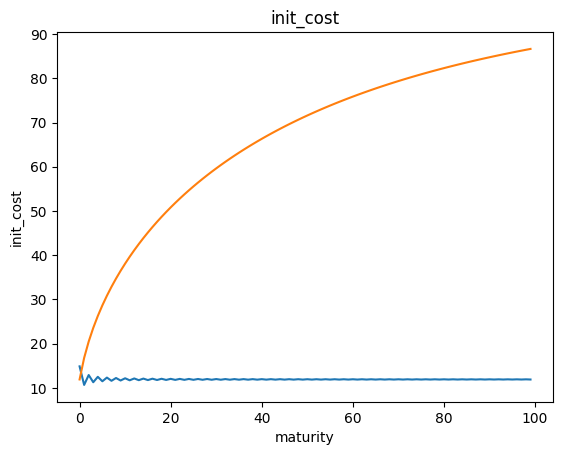

In [ ]:
#init_costの計算
config = Config()
config.maturity=100
config.strike=100
config.branches_bin=2
config.branches=3
config.S_0=100
config.sigma_ave=0.3
config.mu_ave=0.05-config.sigma_ave**2/2
config.nu=0.005
config.zeta=0.35
config.payoff='call'
model = DL_Model_Risk(config)
model.calculate_init_cost()
#matutiryごとのinit_costの計算
init_costs=[]
for i in range(1,101):
    config.maturity=i
    model = DL_Model_Risk(config)
    init_costs.append(model.calculate_init_cost())
pd.DataFrame(init_costs).to_csv('init_costs.csv')
#plot
import matplotlib.pyplot as plt

#BS_price(100,100,1,0.,0.3,'call')を基準としたいので線を引く
plt.plot(init_costs)
plt.plot([BS_price(100,100,1.,0.,0.3,'call') for i in range(1,101)])
plt.xlabel('maturity')
plt.ylabel('init_cost')
plt.title('init_cost')
plt.show()



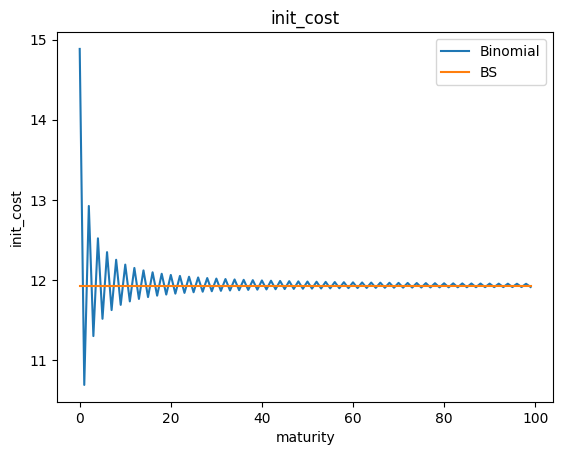

11.923538474048499


In [ ]:
plt.plot(init_costs)
plt.plot([BS_price(100,strike,1.,0.,0.3,'call') for i in range(1,101)])
plt.xlabel('maturity')
plt.ylabel('init_cost')
plt.title('init_cost')
plt.legend(['Binomial','BS'])
plt.show()
print(BS_price(100,100,1.,0.,0.3,'call'))

In [ ]:
# モデルの状態辞書をロード
saved_state_dict = torch.load('singleNN/net_maturity_40_strike_100_models_2_lr_1e-05_units_10_hiddensize_1024.pth')
# DL_Model_Risk インスタンスの初期化

config = Config()
config.units=15
config.hidden_size=1024
config.learning_rate=0.00001
maturity=40
config.maturity=maturity
config.num_epochs=10**4*2
config.strike=100
config.payoff='call'
model_risk = DL_Model_Risk(config)


# ロードしたモデルの状態辞書をネットワークに適用

model_risk.net.load_state_dict(saved_state_dict[f"net"])
# 学習を再開
model_risk.train_network()

epoch : 0,pi_0:0.5799177275110835,loss : 3.680396326046946
epoch : 100,pi_0:0.5798835052004377,loss : 3.677578246272617
epoch : 200,pi_0:0.5798841252813643,loss : 3.6775922983907776
epoch : 400,pi_0:0.5798841649350788,loss : 3.6775940788990624
epoch : 500,pi_0:0.5798841737023789,loss : 3.6775944575552444
epoch : 600,pi_0:0.5798841828109924,loss : 3.6775947333892134
epoch : 700,pi_0:0.5798841887691407,loss : 3.6775949458329933
epoch : 800,pi_0:0.5798841912310191,loss : 3.6775950749928654
epoch : 900,pi_0:0.5798841932736611,loss : 3.6775951704223644
epoch : 1000,pi_0:0.579884195917575,loss : 3.677595268383385
epoch : 1100,pi_0:0.5798841954444496,loss : 3.6775953386298
epoch : 1200,pi_0:0.5798841977561604,loss : 3.6775953978032305
epoch : 1400,pi_0:0.5798841970866491,loss : 3.677595521083447
epoch : 1500,pi_0:0.5798986880246799,loss : 3.678332728134933
epoch : 1600,pi_0:0.580242266532938,loss : 3.6849607771650312
epoch : 1700,pi_0:0.5802740649015358,loss : 3.686713127470682
epoch : 1800,p

,行使価格,最大となるエポック,初期ウェイト,初期株式保有数,ヘッジ誤差,処理時間,平均更新量,学習率,中間層の数,ユニット数
0,100.0,2676.0,0.999996,0.580288,3.687911,19618.0,0.0,0.00001,12.0,1024.0


In [ ]:
for maturity in [40,45]:

  config = Config()
  config.units=5

  hidden_size=750
  config.hidden_size=hidden_size
  config.learning_rate=0.00001
  config.maturity=maturity
  config.num_epochs=10**4*4
  config.strike=80
  config.payoff='call'
  model_risk = DL_Model_Risk(config)
  model_risk.train_network()


epoch : 0,pi_0:0.8194395267297727,loss : 0.29695211106763963
epoch : 100,pi_0:0.8010321570792555,loss : 1.6548993962926488
epoch : 200,pi_0:0.8008999892724893,loss : 1.6678048757809165
epoch : 300,pi_0:0.8007404730203608,loss : 1.673237257553069
epoch : 400,pi_0:0.8005798226048177,loss : 1.67656677798891
epoch : 500,pi_0:0.8005101224105864,loss : 1.6776241638045803
epoch : 600,pi_0:0.8004276077936859,loss : 1.6786786409203387
epoch : 700,pi_0:0.8003440060122761,loss : 1.6795991354214266
epoch : 800,pi_0:0.8002799309215128,loss : 1.6801975974319703
epoch : 900,pi_0:0.800206157674411,loss : 1.680850975123576
epoch : 1000,pi_0:0.8001225622134568,loss : 1.6815702566528898
epoch : 1100,pi_0:0.8000398405571173,loss : 1.6823240535408104
epoch : 1200,pi_0:0.7999799753641827,loss : 1.6827503283896021
epoch : 1300,pi_0:0.7999194439435459,loss : 1.6831509344139022
epoch : 1400,pi_0:0.7998575197160829,loss : 1.6835520747263217
epoch : 1500,pi_0:0.7997931439982721,loss : 1.6839718709820772
epoch : 

: 